In [71]:
#imports streamlit 
cd 'C:\Users\15199\Downloads\Capstone Project'
streamlit run streamlit_app.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from joblib import dump
pd.set_option('display.max_columns', None)

In [60]:
df = pd.read_csv('data/complete.csv')
days = pd.read_csv('data/daysviz.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [52]:
mag_count = df.value_counts('mag')

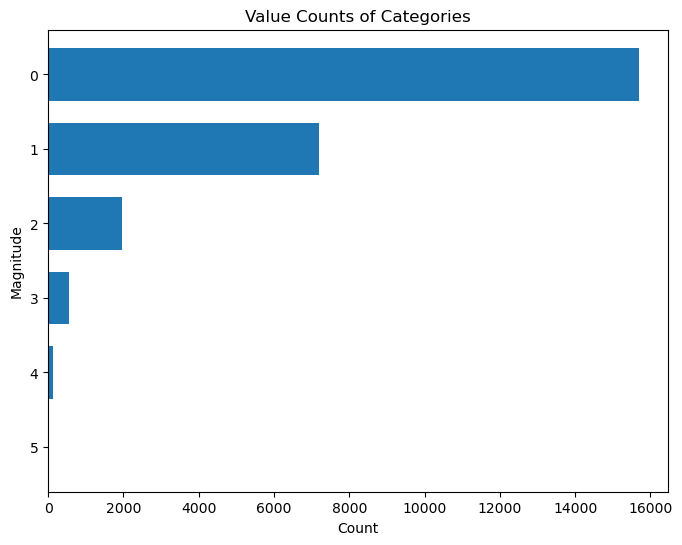

In [53]:
plt.figure(figsize=(8, 6))
mag_count.sort_index().plot(kind='barh', width=0.7)  # Reversing axes
plt.ylabel('Magnitude')
plt.xlabel('Count')
plt.title('Value Counts of Categories')
plt.gca().invert_yaxis()
plt.show()

In [54]:
month_counts = df['mo'].value_counts().sort_index()

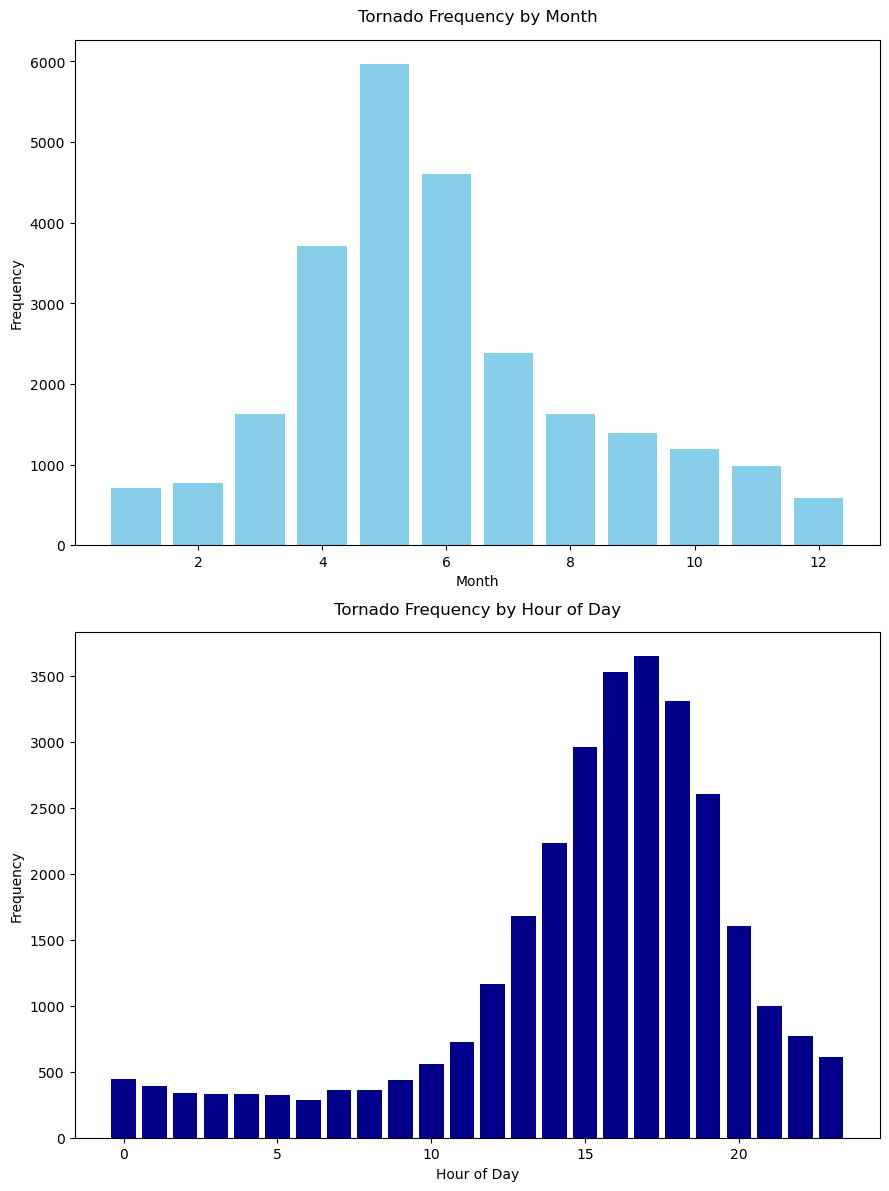

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(9, 12))

axes[0].bar(month_counts.index, month_counts.values, color='skyblue')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tornado Frequency by Month', y=1.02)

axes[1].bar(days['hour'], days['count'], color='darkblue')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Tornado Frequency by Hour of Day', y=1.02)

plt.tight_layout()
plt.show()

In [63]:
import ipywidgets

def speed_by_mag(magnitude):
    filtered_df = df[df['mag'] == magnitude]

    avg_wind_speed_10m = filtered_df['Average_Wind_Speed_10m'].mean()
    avg_wind_speed_100m = filtered_df['Average_Wind_Speed_100m'].mean()

    positions = [0.5, 0.9]

    plt.figure(figsize=(6, 5))

    plt.bar(positions, [avg_wind_speed_10m, avg_wind_speed_100m], width=0.2)
    plt.xticks(positions, ['Wind Speed (10m)', 'Wind Speed (100m)'])
    plt.xlabel('Wind Speed Measurement')
    plt.ylabel('Average Wind Speed')
    plt.title(f'Average Wind Speeds at Different Heights for Magnitude {magnitude}')
    plt.ylim(0, 40)
    plt.show()

In [208]:
ipywidgets.interact(speed_by_mag, magnitude=(0,5,1))

interactive(children=(IntSlider(value=2, description='magnitude', max=5), Output()), _dom_classes=('widget-int…

<function __main__.speed_by_mag(magnitude)>

In [65]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['len']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    len   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     217.3
Date:                Sat, 13 Apr 2024   Prob (F-statistic):          3.22e-139
Time:                        17:35:57   Log-Likelihood:                -81731.
No. Observations:               25546   AIC:                         1.635e+05
Df Residuals:                   25542   BIC:                         1.635e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      95.5528      8.213     11.634      0.000      79.454     111.651
Average_Wind_Speed_10m     -0.3432      0.023    -14.676      0.000      -0.389      -0.297
Average_Wind_Speed_100m     0.2687      0.015     17.377      0.000       0.238       0.299
Average_Pressure_msl       -0.0931      0.008    -11.514      0.000      -0.109      -0.077
==============================================================================
Omnibus:                    29745.848   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4778601.811
Skew:                           6.025   Prob(JB):                         0.00
Kurtosis:                      68.911   Cond. No.                     2.24e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

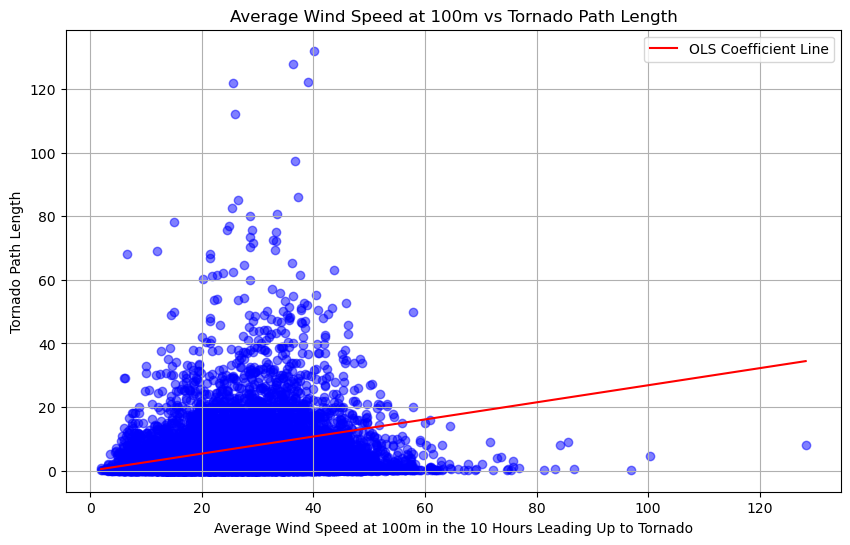

In [66]:
coefficient_value = results.params['Average_Wind_Speed_100m']

wind_speed_values = np.linspace(min(df['Average_Wind_Speed_100m']), max(df['Average_Wind_Speed_100m']), 100)

predicted_path_length = coefficient_value * wind_speed_values

plt.figure(figsize=(10, 6))
plt.scatter(df['Average_Wind_Speed_100m'], df['len'], color='blue', alpha=0.5)

plt.plot(wind_speed_values, predicted_path_length, color='red', label='OLS Coefficient Line')

plt.title('Average Wind Speed at 100m vs Tornado Path Length')
plt.xlabel('Average Wind Speed at 100m in the 10 Hours Leading Up to Tornado')
plt.ylabel('Tornado Path Length')
plt.legend()
plt.grid(True)

plt.show()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)
results = model.fit()

y_pred = results.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 33.88912858447809
Root Mean Squared Error (RMSE): 5.821436986215525
Mean Absolute Error (MAE): 3.2238898048560625
R-squared (R2) Score: 0.01908388053836374


In [81]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
gbmclass = GradientBoostingClassifier(random_state=42)
gbmclass.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [76]:
dump(gbmclass, 'gbmclass_model.joblib')

['gbmclass_model.joblib']

In [75]:
y_pred_gbm = gbmclass.predict(X_test)

accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("GBM Accuracy:", accuracy_gbm)

print("GBM Classification Report:")
print(classification_report(y_test, y_pred_gbm))

GBM Accuracy: 0.6174168297455969
GBM Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.76      3176
           1       0.38      0.01      0.01      1403
           2       0.00      0.00      0.00       400
           3       0.09      0.01      0.02       106
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         3

    accuracy                           0.62      5110
   macro avg       0.18      0.17      0.13      5110
weighted avg       0.49      0.62      0.48      5110



Random Forest

In [37]:
rfclass = RandomForestClassifier(random_state=42)
rfclass.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = rfclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5906066536203523
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.84      0.74      3176
           1       0.35      0.22      0.27      1403
           2       0.28      0.07      0.11       400
           3       0.14      0.04      0.06       106
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         3

    accuracy                           0.59      5110
   macro avg       0.24      0.20      0.20      5110
weighted avg       0.53      0.59      0.54      5110



In [82]:
svmclass = SVC(kernel='rbf', random_state=42)
svmclass.fit(X_train, y_train)

SVC(random_state=42)

In [83]:
y_pred_svm = svmclass.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.6215264187866928
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      3176
           1       0.00      0.00      0.00      1403
           2       0.00      0.00      0.00       400
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         3

    accuracy                           0.62      5110
   macro avg       0.10      0.17      0.13      5110
weighted avg       0.39      0.62      0.48      5110



C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
dump(svmclass, 'svc_model.joblib')

['svc_model.joblib']

In [88]:
df['mag'] = df['mag'].replace(5, 4)

In [89]:
df['mag'] = df['mag'].replace(4, 3)

In [90]:
df['mag'] = df['mag'].replace(3, 2)

In [91]:
df.value_counts('mag')

mag
0    15686
1     7184
2     2676
Name: count, dtype: int64

In [92]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [138]:
tunedRFclass = RandomForestClassifier(bootstrap=True, 
                                       max_depth=25, 
                                       max_features='log2',
                                       min_samples_leaf=15, 
                                       min_samples_split=15, 
                                       n_estimators=150,
                                       class_weight={0: 1, 1: 1.3, 2: 2},
                                     )

In [139]:
tunedRFclass.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.3, 2: 2}, max_depth=25,
                       max_features='log2', min_samples_leaf=15,
                       min_samples_split=15, n_estimators=150)

In [140]:
y_pred = tunedRFclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.601064662595898
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75      3940
           1       0.34      0.10      0.15      1785
           2       0.19      0.02      0.04       662

    accuracy                           0.60      6387
   macro avg       0.38      0.35      0.31      6387
weighted avg       0.50      0.60      0.51      6387



In [145]:
dump(tunedRFclass, 'rftunedmodel.joblib')

['rftunedmodel.joblib']

In [146]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [147]:
rfoversampled = RandomForestClassifier(max_depth=10, 
                                       min_samples_leaf=1, 
                                       min_samples_split=2, 
                                       n_estimators=300)


rfoversampled.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(max_depth=10, n_estimators=300)

In [148]:
y_pred = rfoversampled.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.3845310787537185
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.41      0.52      3940
           1       0.31      0.25      0.27      1785
           2       0.15      0.61      0.24       662

    accuracy                           0.38      6387
   macro avg       0.39      0.42      0.34      6387
weighted avg       0.54      0.38      0.42      6387



In [149]:
dump(rfoversampled, 'SMOTEmodel.joblib')

['SMOTEmodel.joblib']

In [141]:
class_weights = {0: 0.8, 1: 2, 2: 3}

weightedrf = RandomForestClassifier()

weightedrf.fit(X_train, y_train)

RandomForestClassifier()

In [142]:
y_pred = weightedrf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5861906998590888
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      3940
           1       0.35      0.19      0.25      1785
           2       0.29      0.09      0.14       662

    accuracy                           0.59      6387
   macro avg       0.43      0.38      0.37      6387
weighted avg       0.52      0.59      0.54      6387



In [181]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'verbosity': 1,
    'max_depth': 6,
    'min_child_weight': 5,
    'eta':0.29,
    'alphaa':10
}

xgb_classifier = xgb.XGBClassifier(**params)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

C:\Users\15199\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "alphaa" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5984030061061532


In [182]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.94      0.75      3940
           1       0.29      0.07      0.11      1785
           2       0.27      0.01      0.02       662

    accuracy                           0.60      6387
   macro avg       0.40      0.34      0.29      6387
weighted avg       0.49      0.60      0.49      6387



In [163]:
dump(xgb_classifier, 'XGBmodel.joblib')

['XGBmodel.joblib']

In [110]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'min_data_in_leaf': 20,
    'is_unbalance': True,
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

y_pred_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 19159, number of used features: 3
[LightGBM] [Info] Start training from score -0.489260
[LightGBM] [Info] Start training from score -1.266559
[LightGBM] [Info] Start training from score -2.252650
Accuracy: 0.615312353217473
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.76      3940
           1       0.41      0.02      0.04      1785
           2       0.20      0.00      0.01       662

    accuracy                           0.62      6387
   macro avg       0.41      0.34      0.27      6387
weighted avg       0.52      0.62      0.48      6387



In [164]:
dump(lgb_model, 'LGBmodel.joblib')

['LGBmodel.joblib']